In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/CS594 - DNLP/Assignments/Assignment 1/

/content/drive/My Drive/CS594 - DNLP/Assignments/Assignment 1


In [3]:
import pandas as pd
import numpy as np
import os
# import src
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
pip install autocorrect

     |████████████████████████████████| 1.8MB 9.2MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.1.1-cp36-none-any.whl size=1812206 sha256=4e9b5d461a47662eaa66168efd72140a5a04ea7a21eb6ab39b7855a2b8742ad9
  Stored in directory: /root/.cache/pip/wheels/77/45/a0/6a150c540d0ae10e8d663a67d5033c82d81bacea0e16ecc940
Successfully built autocorrect


In [6]:
import nltk
# nltk.download()
import string
from nltk.tokenize import word_tokenize
import random
import pickle
from nltk.corpus import stopwords

from autocorrect import Speller
# from pycontractions import Contractions

# from spellchecker import SpellChecker

import re
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 

from hyperopt import fmin, tpe, hp

In [8]:
from numpy import asarray
from numpy import zeros
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout, MaxPool1D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional

In [9]:
# # Load your favorite word2vec model
# cont = Contractions('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
# text = "we're"
# text = list(cont.expand_texts([text], precise=True))[0]

In [10]:
def conv_dataframes(pos_path, neg_path):
    with open(pos_path,'r',encoding='latin1') as f:
        data_p = f.readlines()
#     print(data_p[11])
    with open(neg_path,'r',encoding='latin1') as f:
        data_n = f.readlines()
    pos_data = shuffle(pd.DataFrame(data_p, columns = ["Doc Text"]))
#     pos_data['Sentiment'] = 1
#     pos_data.columns = ["Doc Text", "Sentiment"]
    neg_data = shuffle(pd.DataFrame(data_n, columns = ["Doc Text"]))
#     neg_data['Sentiment'] = -1
#     neg_data.columns = ["Doc Text", "Sentiment"]
    return pos_data, neg_data


## The code for pos tagging and lemmatize sentence is fron the following link:
 ### https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

In [11]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [12]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
#     print(wordnet_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#         if tag is not None:
#             lemmatized_sentence.append(lemmatizer.lemmatize(word, tag)) 

    return " ".join(lemmatized_sentence)

In [13]:
# print(lemmatizer.lemmatize("I am loving it")) #I am loving it
# print(lemmatizer.lemmatize("loving")) #loving
# print(lemmatizer.lemmatize("loving", "v")) #love
# print(lemmatize_sentence("I am loving it")) #I be love it

In [14]:
def text_preprocessing(data):
    data["Doc Text"] = data["Doc Text"].str.replace('\n\n', ' ')
    data["Doc Text"] = data["Doc Text"].str.replace('[^\w\s]',' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\s+[a-zA-Z]\s+',' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\^[a-zA-Z]\s+',' ')

    data["Doc Text"] = data["Doc Text"].str.replace('\s+',' ')

    # Remove stop words from text
    data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_list]))
    
#     data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([lemmatizer.lemmatize(y) for y in x.split()]))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: lemmatize_sentence(x))

    return data

In [15]:
def create_vocab(pos_data, neg_data):
    temp_pos = text_preprocessing(pos_data)
    temp_neg = text_preprocessing(neg_data)
#     temp_pos2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_pos['Doc Text']])
#     temp_neg2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_neg['Doc Text']]) 
#     temp_pos["Doc Text Tokens"] = temp_pos2 
#     temp_neg["Doc Text Tokens"] = temp_neg2
    return temp_pos, temp_neg

In [30]:
file_path  = 'rt-polaritydata' 
pos_path = os.path.join(file_path, 'rt-polarity.pos')
neg_path = os.path.join(file_path, 'rt-polarity.neg')

In [31]:
pos_data, neg_data = conv_dataframes(pos_path, neg_path)
pos_data.head()

what really surprises about wisegirls is its low-key quality and genuine tenderness . 



,Doc Text
53,sandra nettelbeck beautifully orchestrates the...
1710,"a sensitive , moving , brilliantly constructed..."
460,"it's fun , but the code-talk will fly right ov..."
1786,you might want to take a reality check before ...
2848,"all comedy is subversive , but this unrelentin..."


In [32]:
pos_data['Doc Text'][11]

'what really surprises about wisegirls is its low-key quality and genuine tenderness . \n'

In [33]:
# hm_lines = 5331

# tokenizer = nltk.RegexpTokenizer(r"\w+")
# spell = Speller(lang='en')
# # spell = SpellChecker()

# stop_words = set(stopwords.words('english'))
stop_list = stopwords.words('english')

lemmatizer = WordNetLemmatizer() 

vocab_p, vocab_n = create_vocab(pos_data, neg_data)

vocab_p['Sentiment'] = 1
vocab_n['Sentiment'] = 0

In [34]:
vocab_p.head()

,Doc Text,Sentiment
53,sandra nettelbeck beautifully orchestrate tran...,1
1710,sensitive move brilliantly construct work,1
460,fun code talk fly right everyone head,1
1786,might want take reality check pay full ticket ...,1
2848,comedy subversive unrelenting bleak insistence...,1


In [35]:
len(vocab_p)

5331

## Splitting the data into training, validation, and testing

## Just splitting into training and test for now, will split training further into validation in the model

In [36]:
vocab_p_train, vocab_p_test= train_test_split(vocab_p, test_size = 0.2)
# vocab_p_train, vocab_p_val = train_test_split(vocab_p_train1, test_size = 600)
vocab_p_test.head()

,Doc Text,Sentiment
3649,visual delight decent popcorn adventure long t...,1
3334,problem lady duke surprisingly manage never gr...,1
1423,pumpkin take admirable look hypocrisy politica...,1
40,newton draw attention like magnet act circle a...,1
3491,film belongs marvelous verdu sexy slip earth m...,1


In [37]:
vocab_p_train.head()

,Doc Text,Sentiment
466,film exhilarate watch sandler liberate constra...,1
1187,fall neatly category good stupid fun,1
541,life affirm vulgar mean like,1
1030,everything love 1982 still everybody want kid ...,1
4389,time do us mira nair new movie audience giddy ...,1


In [38]:
vocab_n_train, vocab_n_test= train_test_split(vocab_n, test_size = 0.2)
# vocab_n_train, vocab_n_val = train_test_split(vocab_n_train1, test_size = 600)
vocab_n_test.head()

,Doc Text,Sentiment
3503,certain cue like happy music suggest movie sup...,0
2333,say fuhgeddaboutit,0
1404,worth see charm quickly fade,0
469,movie weigh glass flat champagne,0
3918,deserves high mark political courage barely ge...,0


In [39]:
training = shuffle(pd.concat([vocab_p_train,vocab_n_train])).reset_index(drop = True)

# validation = pd.concat([vocab_p_val,vocab_n_val]).reset_index(drop = True)

test = pd.concat([vocab_p_test,vocab_n_test]).reset_index(drop = True)
# len(validation)

In [40]:
training.head()

,Doc Text,Sentiment
0,old cad instructs young lad zen art get laid p...,1
1,movie always easy look indeed duty art reflect...,1
2,fill honest performance exceptional detail bar...,1
3,dialogue cumbersome simper soundtrack edit,0
4,less front load shapely two hour version relea...,1


In [41]:
training.to_csv('Training Data.csv')
# validation.to_csv('Validation.csv')
test.to_csv('Test Data.csv')

In [18]:
training = pd.read_csv('Training Data.csv').iloc[:,1:]

training.head()

,Doc Text,Sentiment
0,old cad instructs young lad zen art get laid p...,1
1,movie always easy look indeed duty art reflect...,1
2,fill honest performance exceptional detail bar...,1
3,dialogue cumbersome simper soundtrack edit,0
4,less front load shapely two hour version relea...,1


## Building Glove Dictionary

In [16]:
embeddings = {}
with open("glove.6B.300d.txt", 'r', encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = asarray(values[1:], dtype='float32')
        embeddings[word] = vector

## Embedding Matrix Function

In [19]:
def emb_matrix(t,embeddings):
    # creating a embedding matrix for the words in training data, which will be used as weight matrix for embedding layer
    vocab_size = len(t.word_index) + 1    
    embedding_matrix = zeros((vocab_size, 300))
    for word, i in t.word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, vocab_size

## Building Vanilla RNN, LSTM, and GRU models

In [20]:
def model_vanilla_rnn(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(SimpleRNN(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [21]:
def model_lstm(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(LSTM(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [22]:
def model_gru(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(GRU(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [62]:
# max_length = 40
# epochs = 15
# batch_size = 128
# learning_rate = 0.001

# encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
# training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
# embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
# adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
# model = model_vanilla_rnn(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

# history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.25)
# accuracy = history.history['val_accuracy'][-1]



Epoch 1/15
50/50 [==============================] - 8s 165ms/step - loss: 3.9825 - accuracy: 0.5327 - val_loss: 2.8177 - val_accuracy: 0.5985
Epoch 2/15
50/50 [==============================] - 8s 159ms/step - loss: 2.0675 - accuracy: 0.6850 - val_loss: 1.5092 - val_accuracy: 0.7402
Epoch 3/15
50/50 [==============================] - 8s 166ms/step - loss: 1.2564 - accuracy: 0.7217 - val_loss: 1.0790 - val_accuracy: 0.7209
Epoch 4/15
50/50 [==============================] - 8s 164ms/step - loss: 0.9638 - accuracy: 0.7270 - val_loss: 0.8869 - val_accuracy: 0.7355
Epoch 5/15
50/50 [==============================] - 8s 159ms/step - loss: 0.8533 - accuracy: 0.7206 - val_loss: 0.9179 - val_accuracy: 0.6327
Epoch 6/15
50/50 [==============================] - 8s 159ms/step - loss: 0.7985 - accuracy: 0.7312 - val_loss: 0.8733 - val_accuracy: 0.6421
Epoch 7/15
50/50 [==============================] - 8s 161ms/step - loss: 0.8039 - accuracy: 0.7212 - val_loss: 0.7731 - val_accuracy: 0.7341
Epoch 

In [48]:
# u = {}
# u['max_len'] = max_length
# u['batch'] = batch_size
# u['l_rate'] = learning_rate
# u['epochs'] = epochs

# fig, ax = plt.subplots(1,2,figsize = (20,5))

# ax[0].plot(history.history['loss'], label='Training')
# ax[0].plot(history.history['val_loss'], c='r',label='Validation')
# ax[0].legend(loc='upper left')
# ax[0].title.set_text('Loss plot for the combination ' + str(u)) 

# ax[1].plot(history.history['accuracy'], label='Training')
# ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
# ax[1].legend(loc='upper left')
# ax[1].title.set_text('Accuracy plot for the combination ' + str(u))    

## Using Hyperopt library to tune the Hyperparameters. Here we are splitting the training further into validation with split size 0f 0.25 (which is 0.2 of original data)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

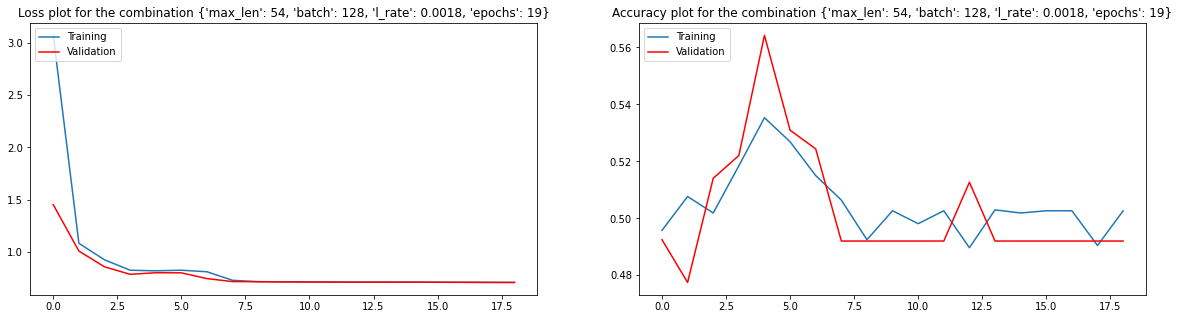

 10%|█         | 1/10 [03:15<29:18, 195.37s/it, best loss: -0.49]

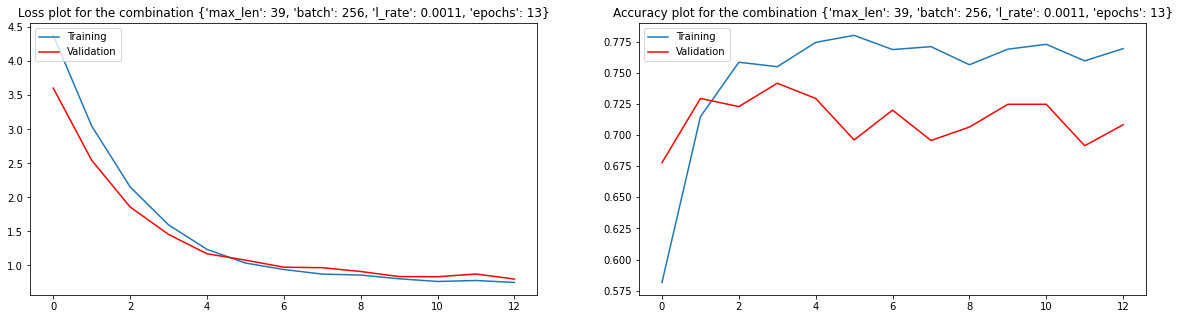

 20%|██        | 2/10 [04:42<21:42, 162.81s/it, best loss: -0.71]

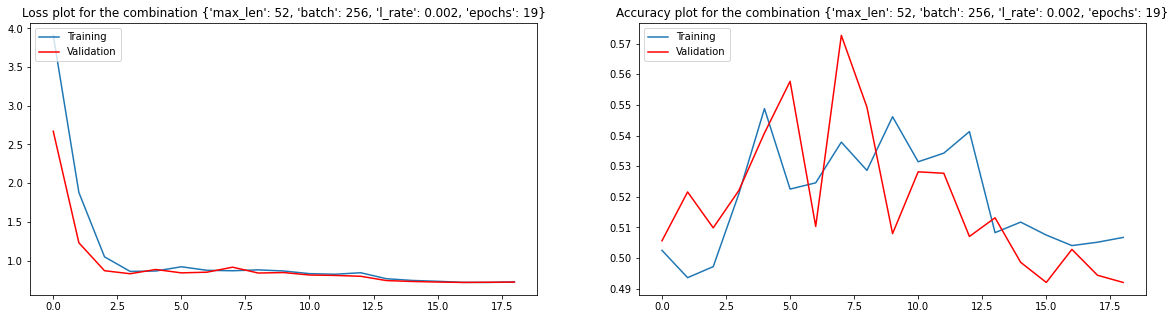

 30%|███       | 3/10 [07:32<19:15, 165.14s/it, best loss: -0.71]

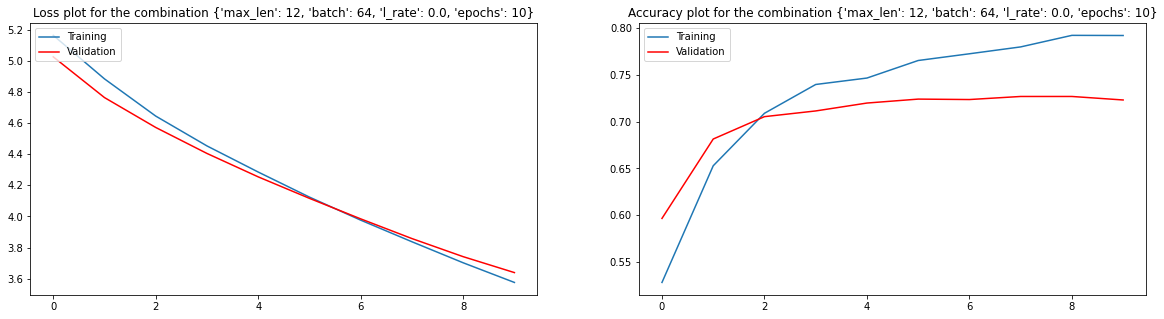

 40%|████      | 4/10 [08:04<12:30, 125.07s/it, best loss: -0.72]

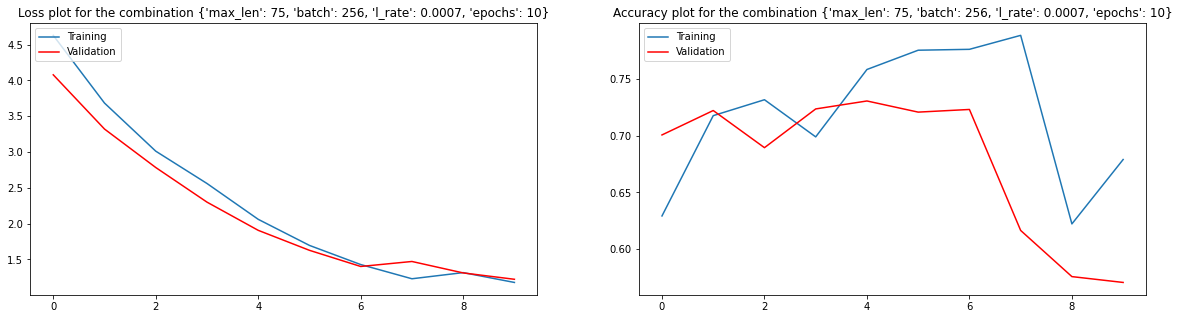

 50%|█████     | 5/10 [10:15<10:34, 126.96s/it, best loss: -0.72]

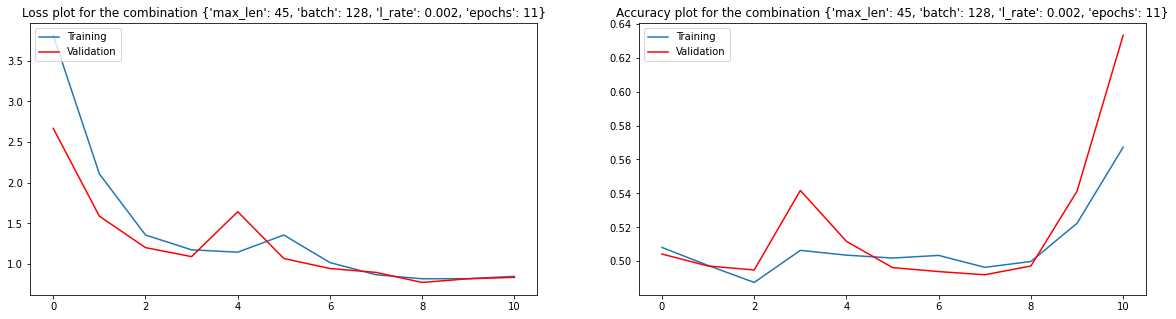

 60%|██████    | 6/10 [11:51<07:50, 117.56s/it, best loss: -0.72]

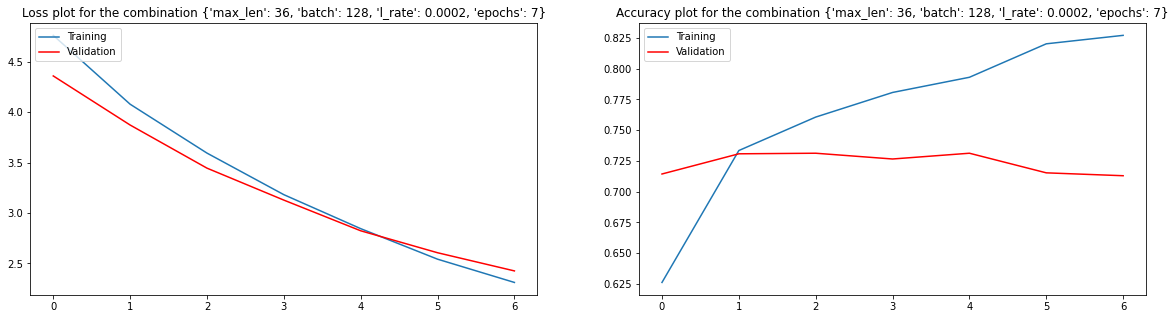

 70%|███████   | 7/10 [12:41<04:51, 97.32s/it, best loss: -0.72] 

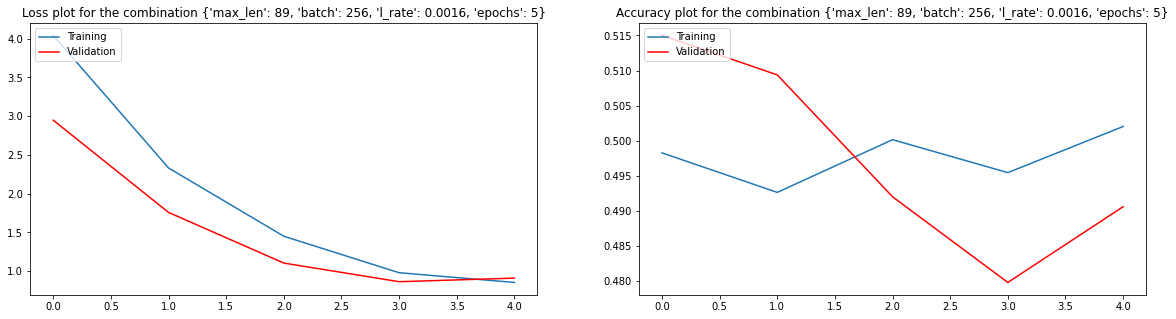

 80%|████████  | 8/10 [14:03<03:05, 92.78s/it, best loss: -0.72]

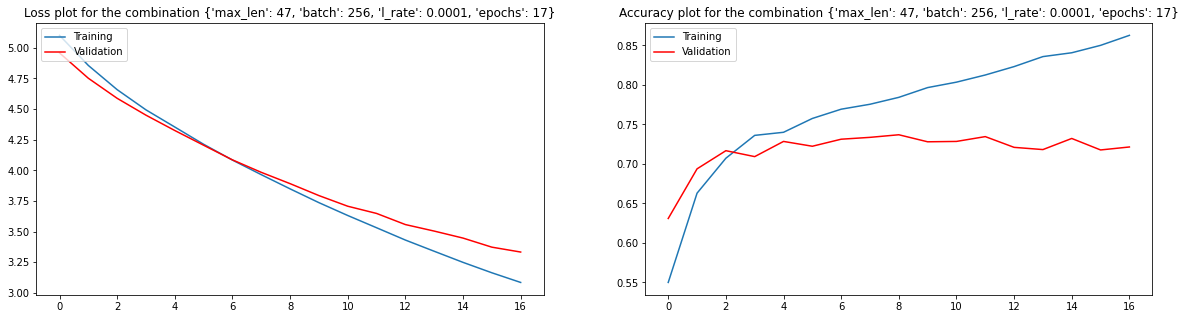

 90%|█████████ | 9/10 [16:24<01:47, 107.07s/it, best loss: -0.72]

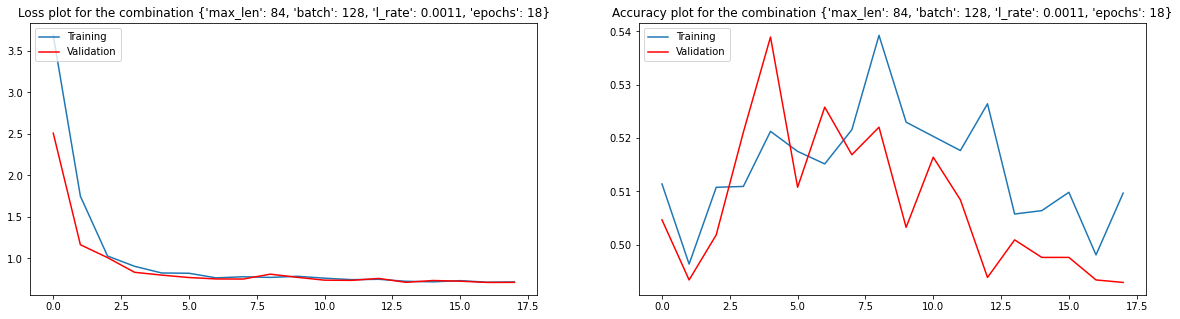

100%|██████████| 10/10 [21:18<00:00, 127.80s/it, best loss: -0.72]
{'batch_size': 0, 'epochs': 5, 'learning_rate': 4.9825482652149365e-05, 'max_length': 8}


In [67]:
def objective_func(args):
    max_length = args['max_length']
#     af_in_simpleRNN = args['af_in_simpleRNN']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
#     padd = args['padd']
#     trunc = args['trunc']
    epochs = args['epochs']
#     kernel_regularizer_coef = args['kernel_regularizer_coef']
#     activity_regularizer_coef = args['activity_regularizer_coef']
#     Dropout_rate = args['Dropout_rate']
    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,4)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn)

In [ ]:
{'batch_size': 0, 'epochs': 7, 'max_length': 59, 'padd': 0, 'trunc': 0}

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

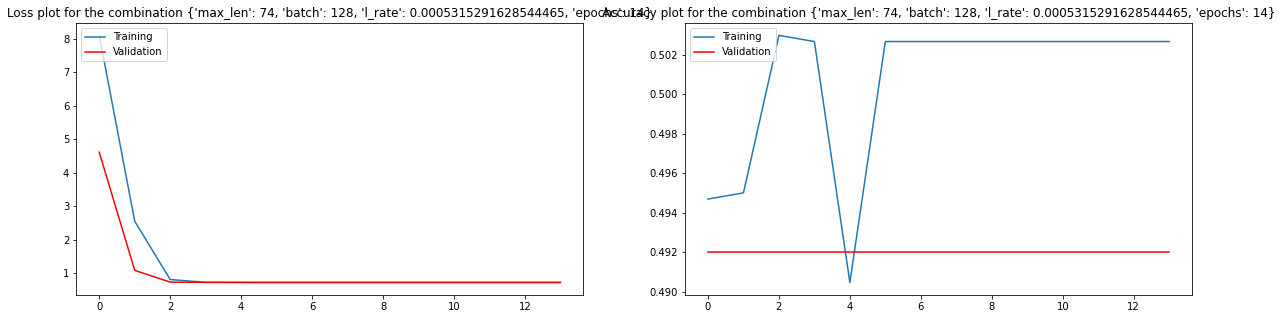

 10%|█         | 1/10 [11:11<1:40:47, 671.89s/it, best loss: -0.49]

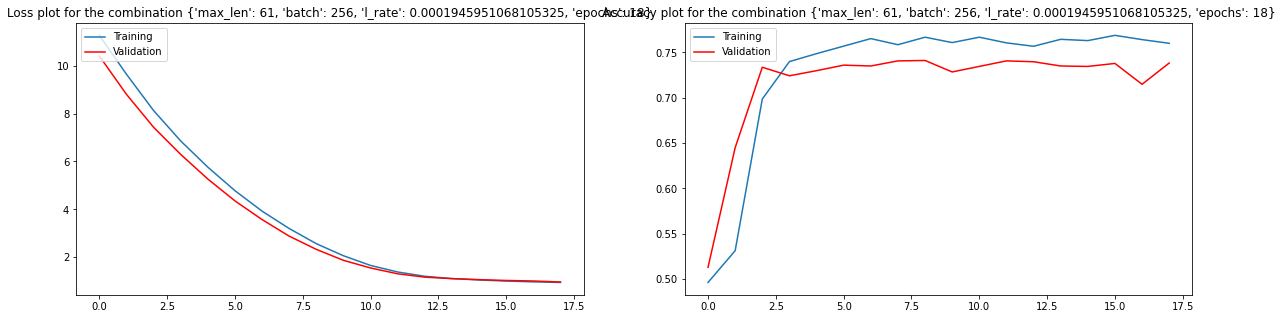

 20%|██        | 2/10 [22:27<1:29:44, 673.08s/it, best loss: -0.74]

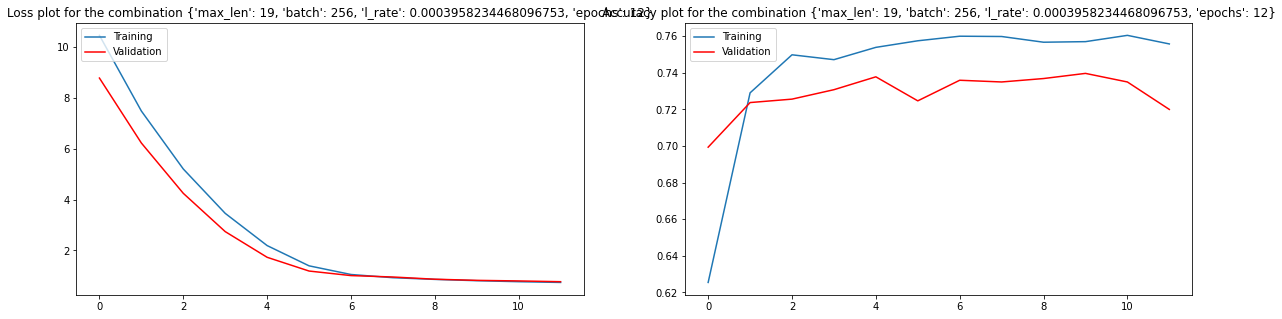

 30%|███       | 3/10 [24:47<59:52, 513.21s/it, best loss: -0.74]  

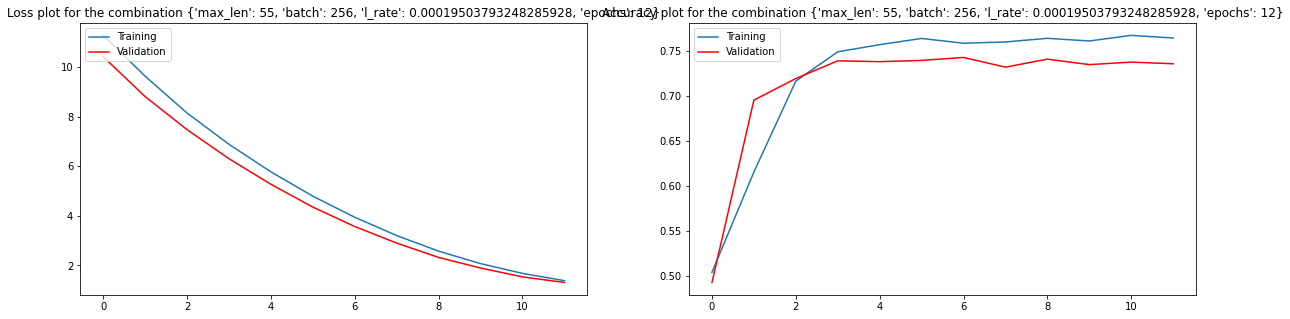

 40%|████      | 4/10 [31:25<47:50, 478.45s/it, best loss: -0.74]

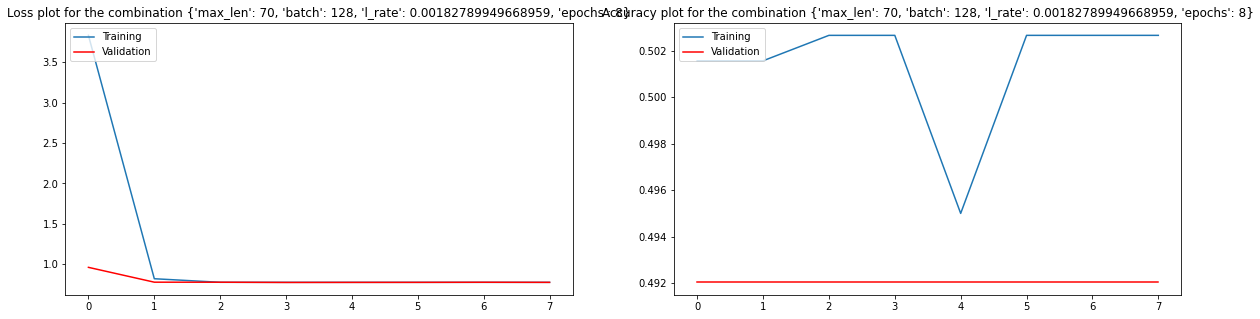

 50%|█████     | 5/10 [37:27<36:58, 443.73s/it, best loss: -0.74]

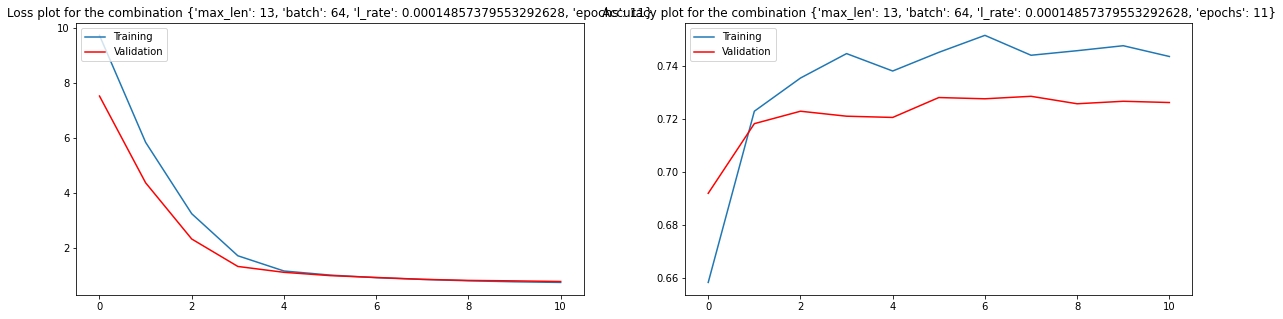

 60%|██████    | 6/10 [39:27<23:05, 346.38s/it, best loss: -0.74]

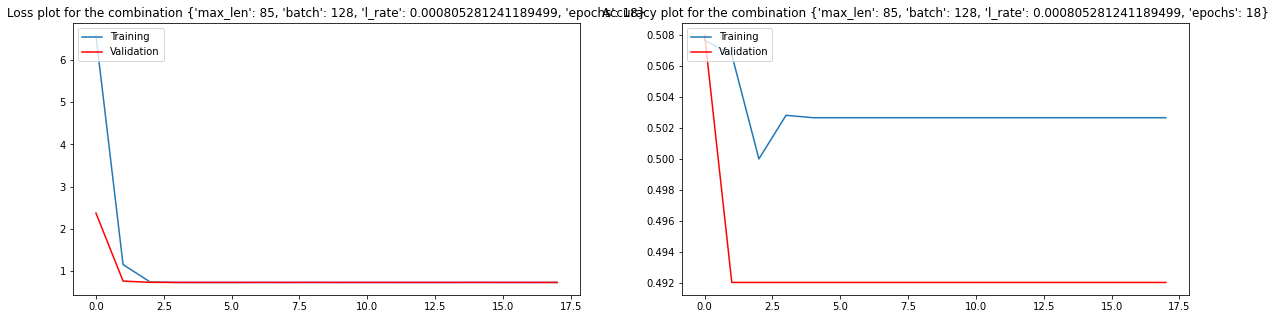

 70%|███████   | 7/10 [55:57<26:59, 539.67s/it, best loss: -0.74]

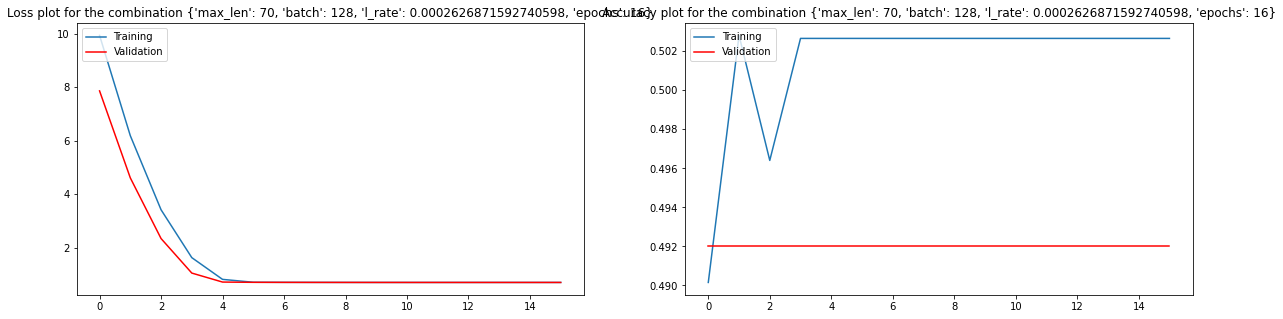

 80%|████████  | 8/10 [1:07:58<19:47, 593.86s/it, best loss: -0.74]

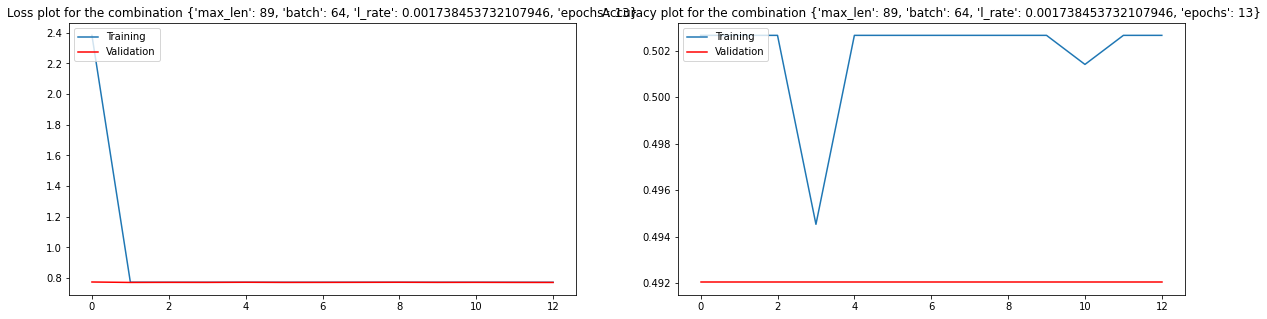

 90%|█████████ | 9/10 [1:22:38<11:19, 679.87s/it, best loss: -0.74]

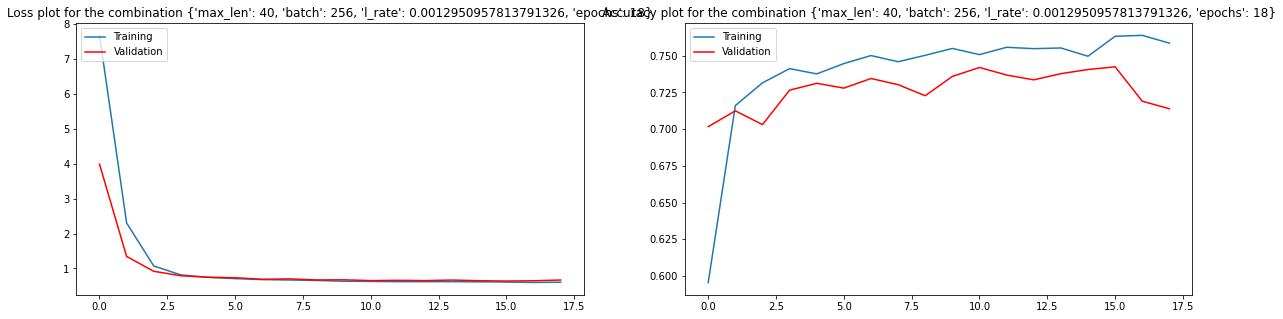

100%|██████████| 10/10 [1:29:47<00:00, 538.78s/it, best loss: -0.74]
{'batch_size': 2, 'epochs': 13, 'learning_rate': 0.0001945951068105325, 'max_length': 57}


In [68]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']
    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_lstm(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_lstm = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_lstm)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

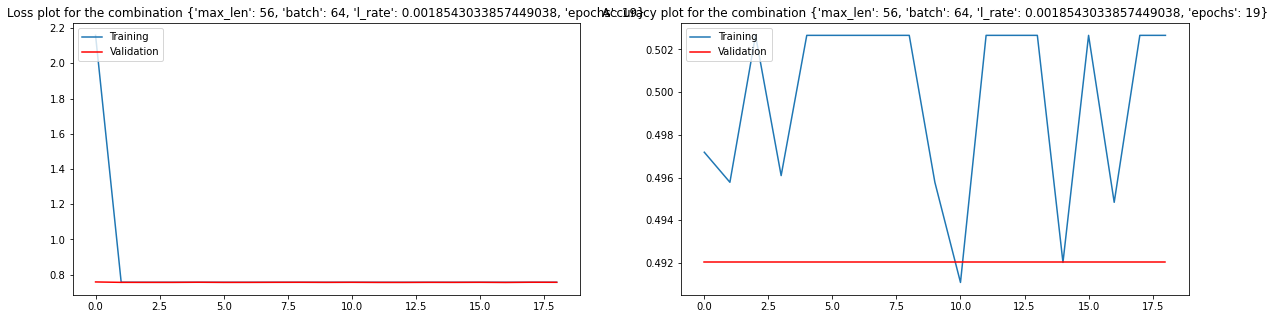

 10%|█         | 1/10 [00:32<04:56, 32.97s/it, best loss: -0.49]

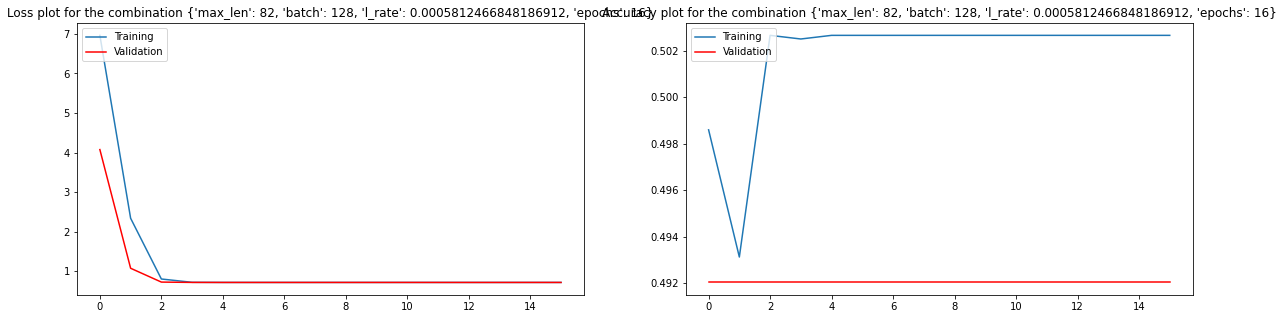

 20%|██        | 2/10 [00:50<03:47, 28.40s/it, best loss: -0.49]

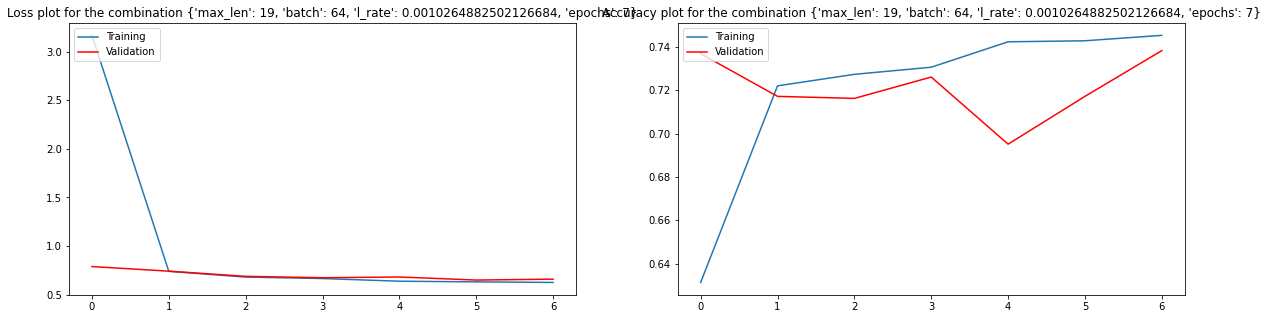

 30%|███       | 3/10 [00:57<02:32, 21.81s/it, best loss: -0.74]

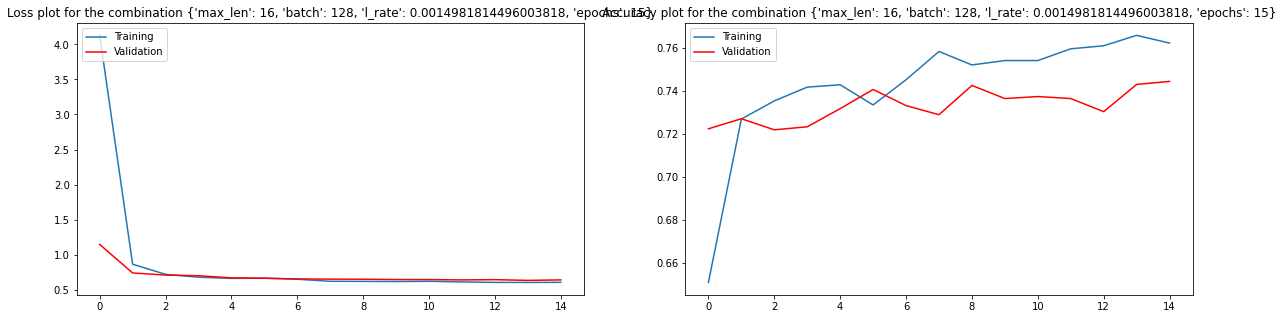

 40%|████      | 4/10 [01:04<01:45, 17.52s/it, best loss: -0.74]

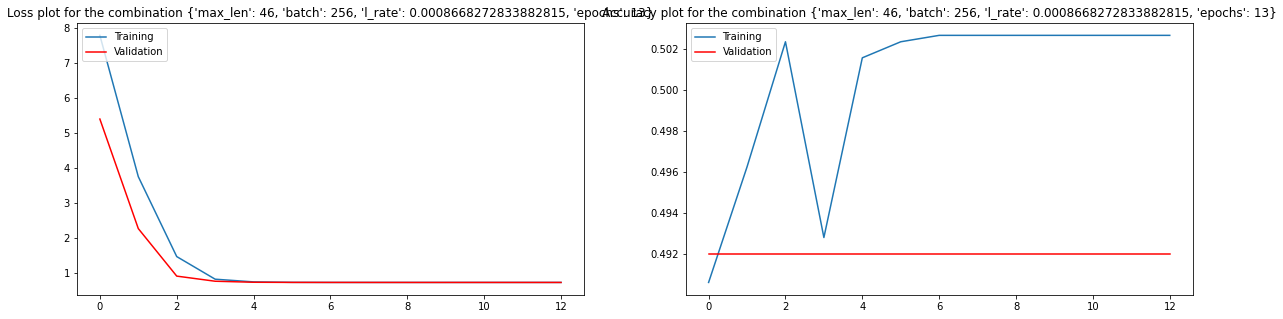

 50%|█████     | 5/10 [01:13<01:14, 14.82s/it, best loss: -0.74]

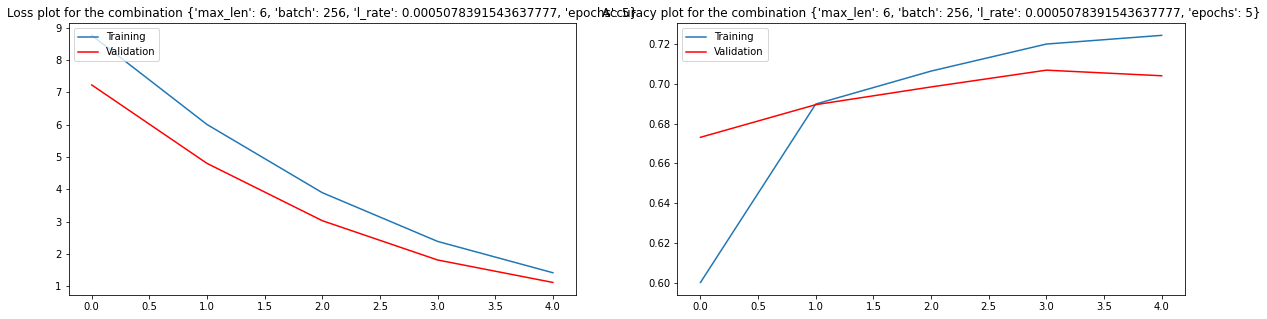

 60%|██████    | 6/10 [01:17<00:46, 11.53s/it, best loss: -0.74]

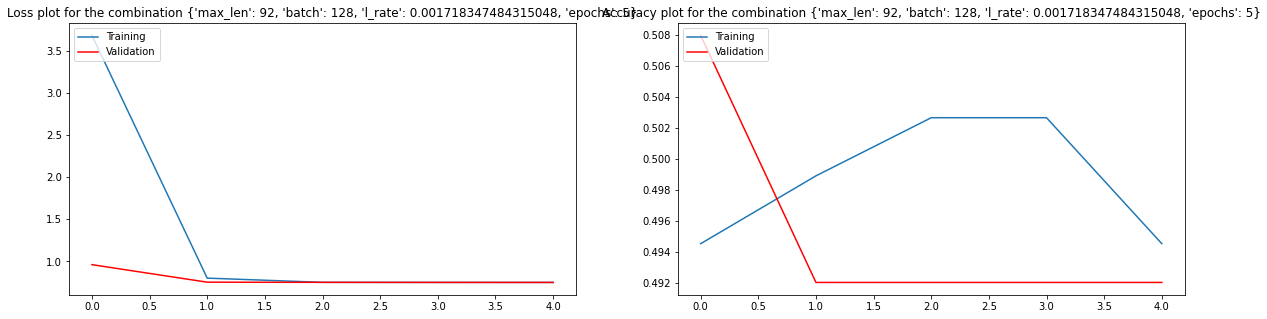

 70%|███████   | 7/10 [01:25<00:31, 10.47s/it, best loss: -0.74]

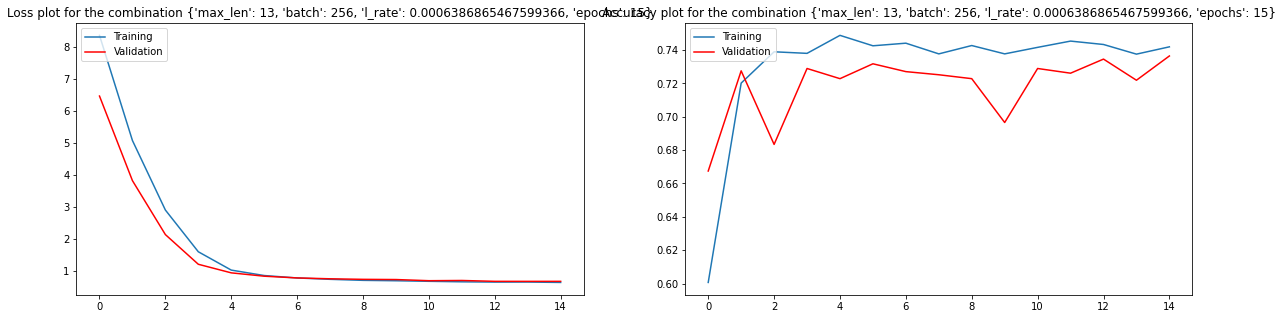

 80%|████████  | 8/10 [01:30<00:18,  9.11s/it, best loss: -0.74]

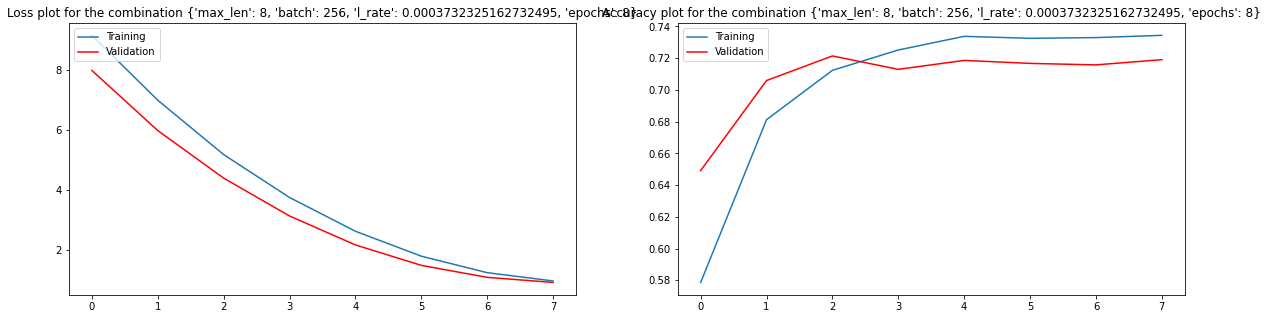

 90%|█████████ | 9/10 [01:35<00:07,  7.59s/it, best loss: -0.74]

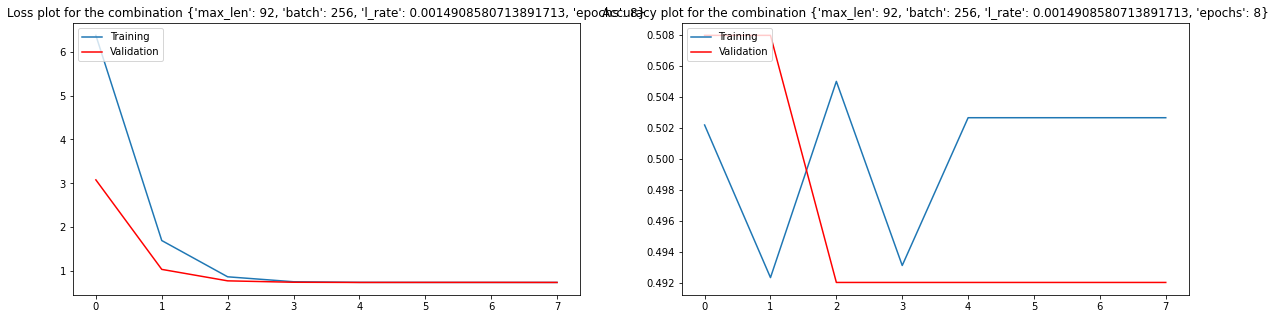

100%|██████████| 10/10 [01:44<00:00, 10.49s/it, best loss: -0.74]
{'batch_size': 0, 'epochs': 2, 'learning_rate': 0.0010264882502126684, 'max_length': 15}


In [23]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']
    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_gru(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_gru = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_gru)

## Taking elementwise max of the hidden states

In [24]:
def model_vanilla_rnn_em(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(SimpleRNN(units = 300, activation = activation,return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
#     model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


In [25]:
def model_lstm_em(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(LSTM(units = 300, activation = activation,return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
#     model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


In [26]:
def model_gru_em(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(GRU(units = 300, activation = activation,return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
#     model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


In [27]:
# max_length = 40
# epochs = 15
# batch_size = 128
# encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
# training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
# embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

# model = model_vanilla_rnn_em(embedding_matrix, vocab_size, max_length, 'tanh', 0.2, 0.001, 0.001)

# history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.2)
# accuracy = history.history['val_accuracy'][-1]

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

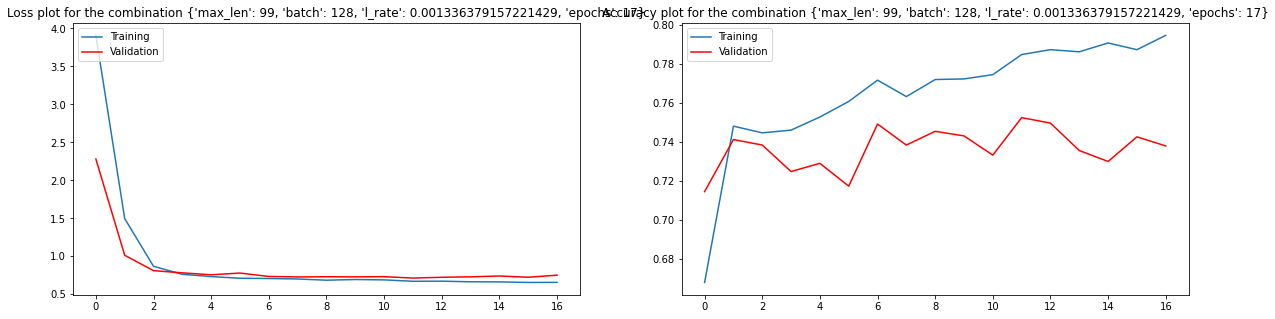

 10%|█         | 1/10 [00:58<08:44, 58.32s/it, best loss: -0.74]

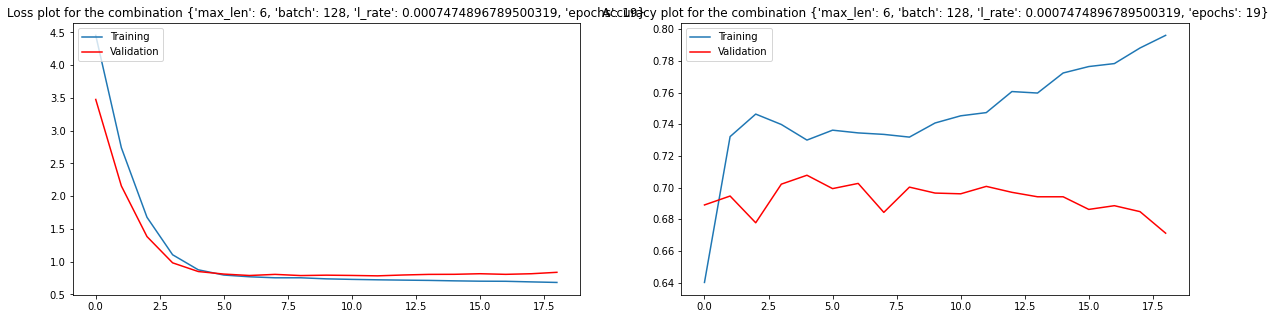

 20%|██        | 2/10 [01:08<05:49, 43.74s/it, best loss: -0.74]

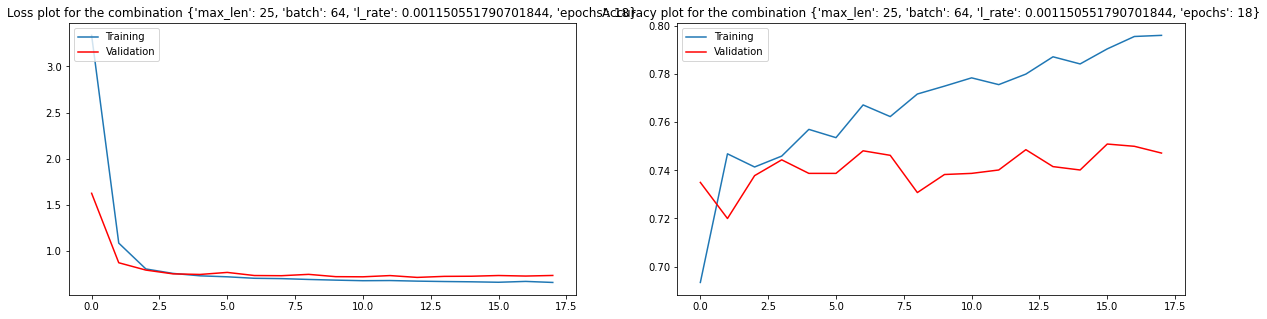

 30%|███       | 3/10 [01:42<04:45, 40.84s/it, best loss: -0.75]

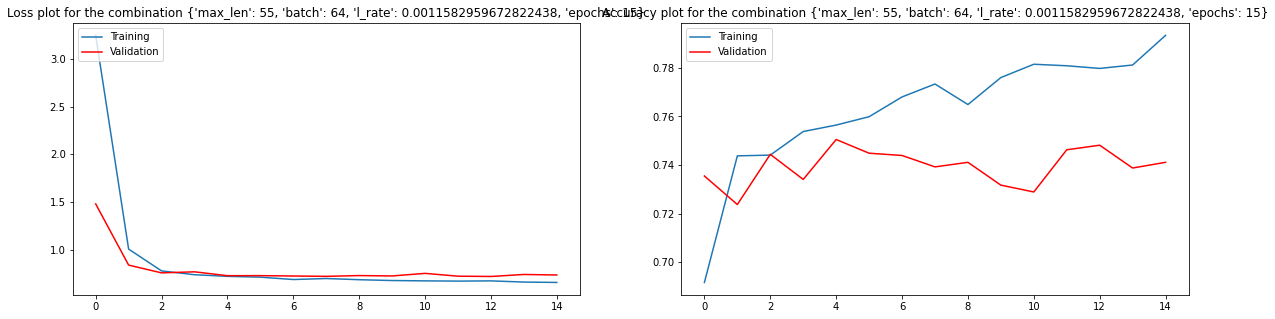

 40%|████      | 4/10 [02:38<04:33, 45.64s/it, best loss: -0.75]

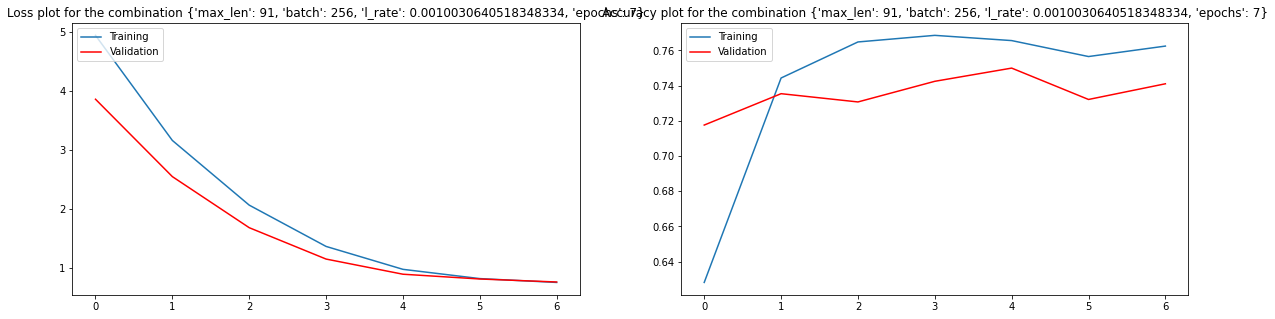

 50%|█████     | 5/10 [02:52<03:00, 36.00s/it, best loss: -0.75]

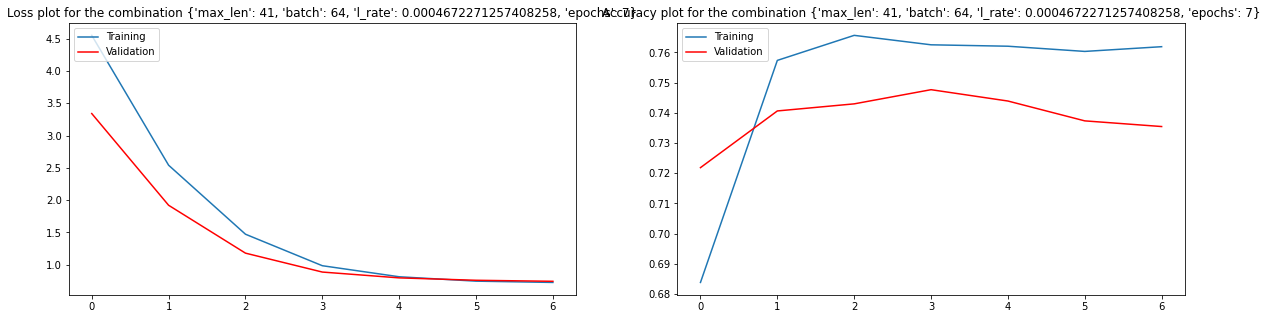

 60%|██████    | 6/10 [03:13<02:06, 31.51s/it, best loss: -0.75]

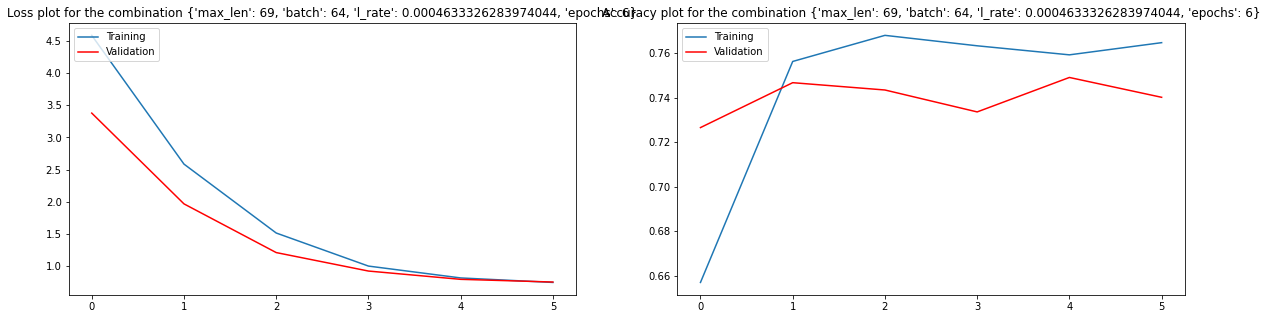

 70%|███████   | 7/10 [03:42<01:32, 30.72s/it, best loss: -0.75]

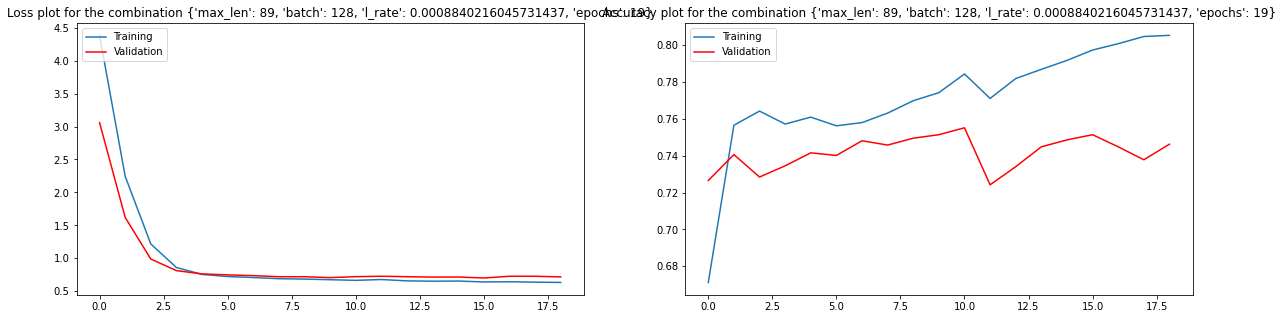

 80%|████████  | 8/10 [04:39<01:17, 38.62s/it, best loss: -0.75]

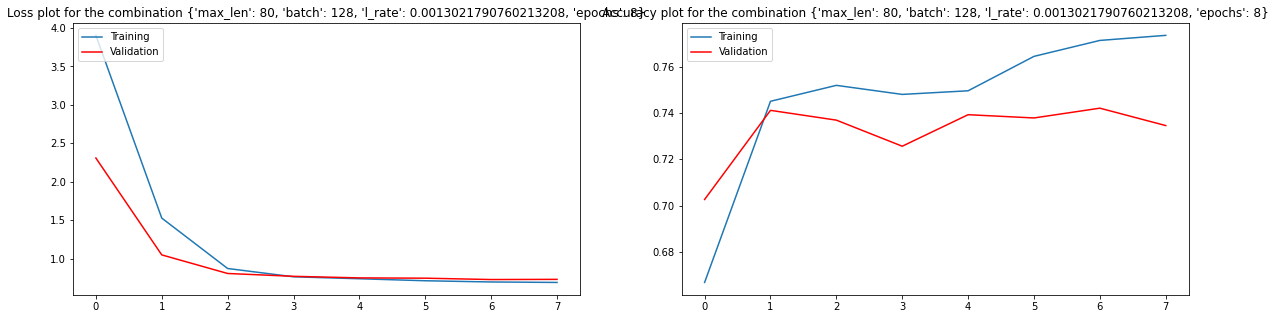

 90%|█████████ | 9/10 [05:03<00:34, 34.15s/it, best loss: -0.75]

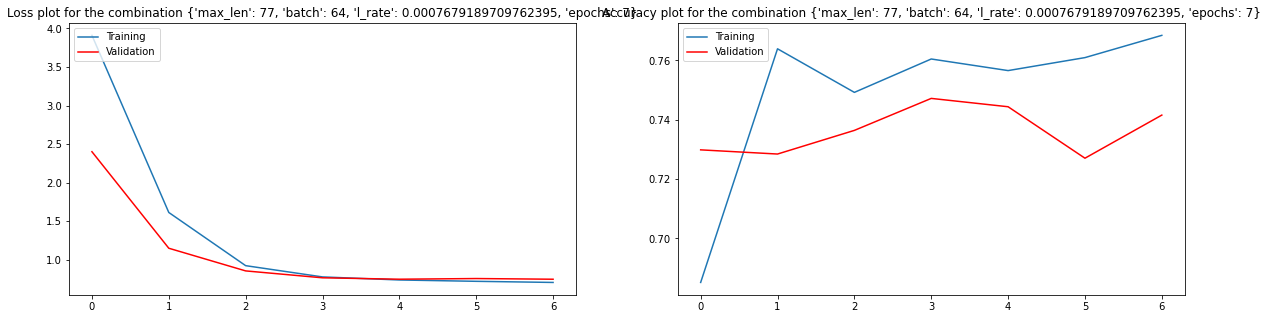

100%|██████████| 10/10 [05:39<00:00, 33.97s/it, best loss: -0.75]
{'batch_size': 0, 'epochs': 13, 'learning_rate': 0.001150551790701844, 'max_length': 21}


In [28]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn_em(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn_em)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

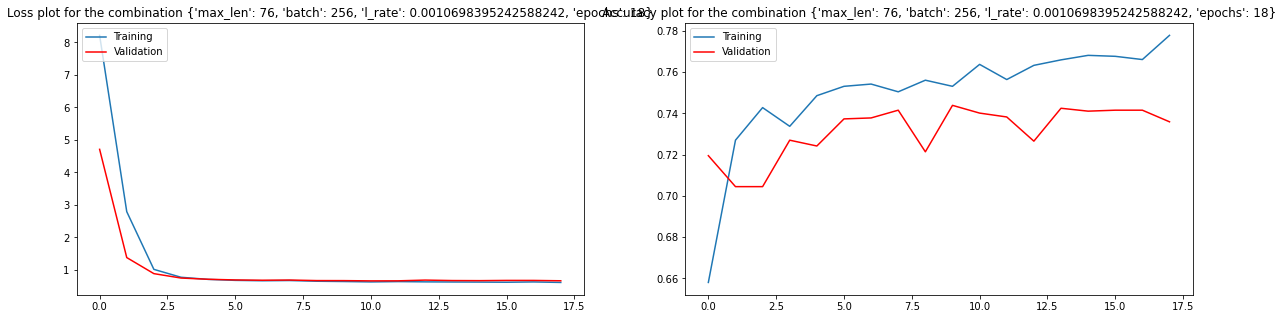

 10%|█         | 1/10 [00:19<02:54, 19.39s/it, best loss: -0.74]

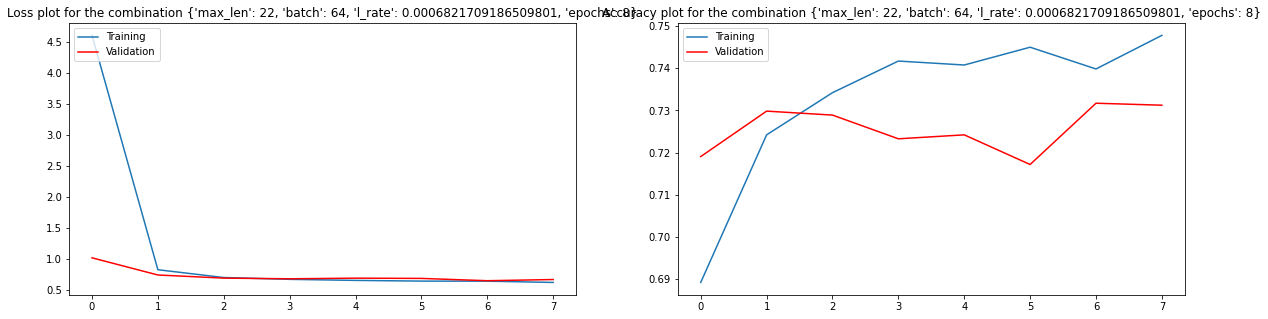

 20%|██        | 2/10 [00:28<02:09, 16.18s/it, best loss: -0.74]

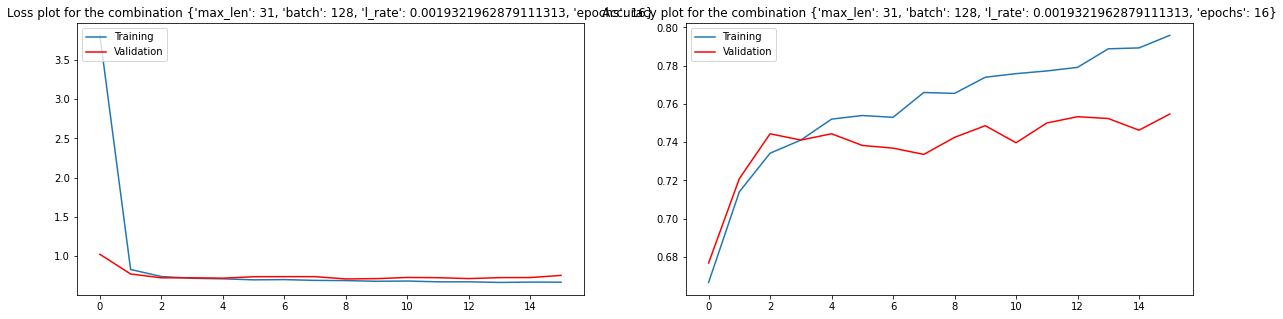

 30%|███       | 3/10 [00:40<01:44, 14.90s/it, best loss: -0.75]

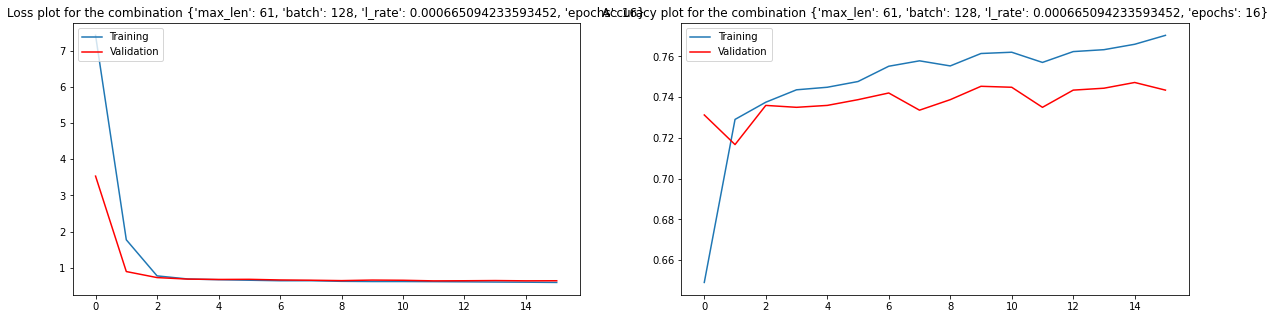

 40%|████      | 4/10 [00:57<01:34, 15.78s/it, best loss: -0.75]

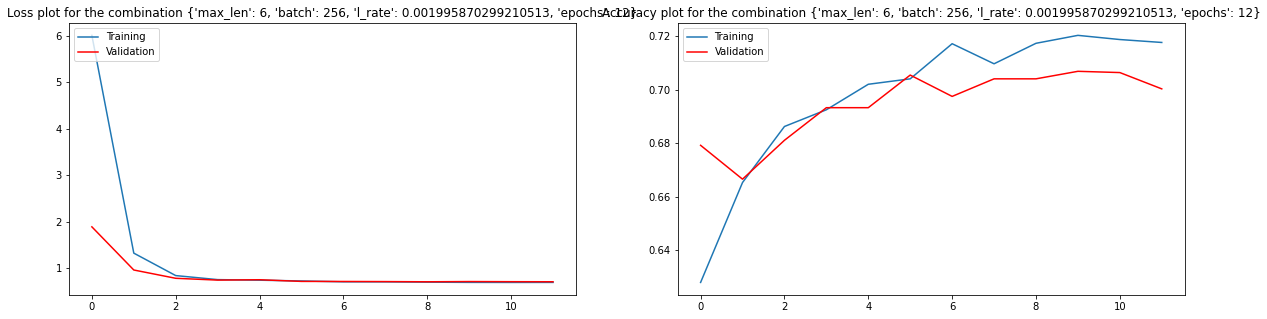

 50%|█████     | 5/10 [01:03<01:03, 12.67s/it, best loss: -0.75]

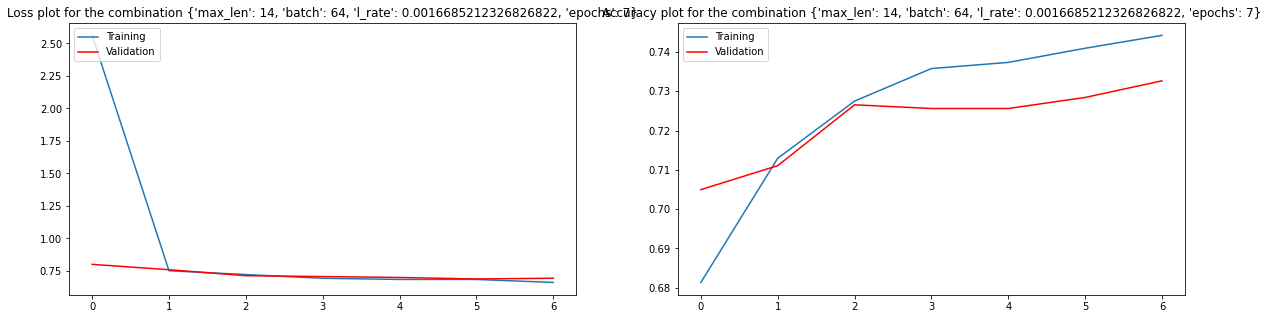

 60%|██████    | 6/10 [01:10<00:43, 10.97s/it, best loss: -0.75]

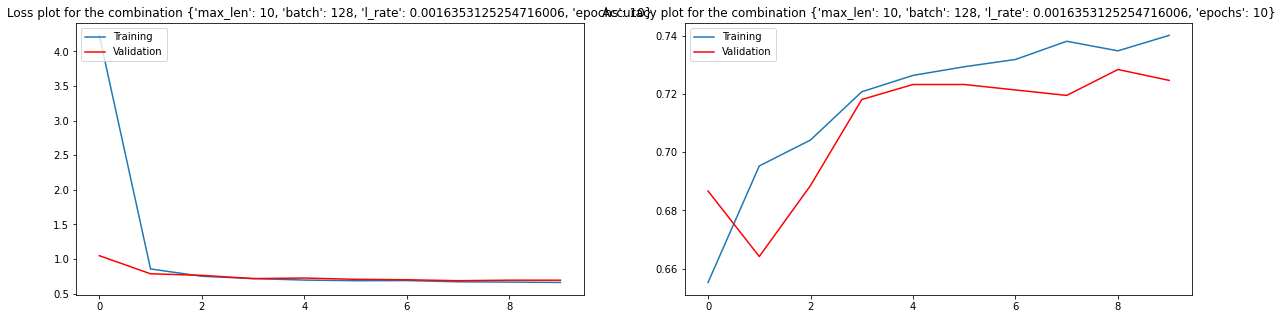

 70%|███████   | 7/10 [01:16<00:28,  9.63s/it, best loss: -0.75]

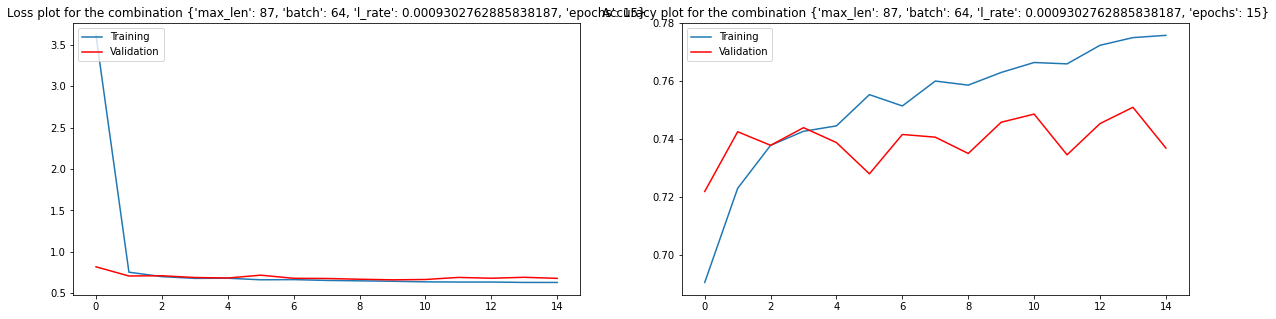

 80%|████████  | 8/10 [01:46<00:31, 15.65s/it, best loss: -0.75]

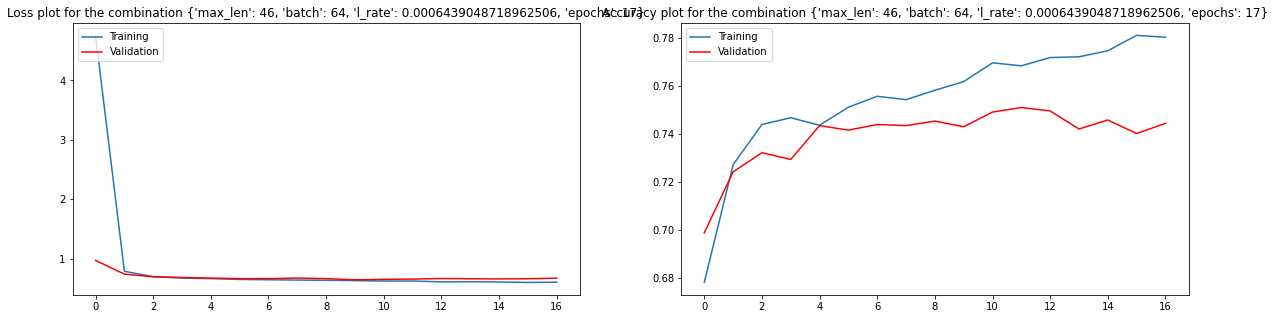

 90%|█████████ | 9/10 [02:07<00:17, 17.38s/it, best loss: -0.75]

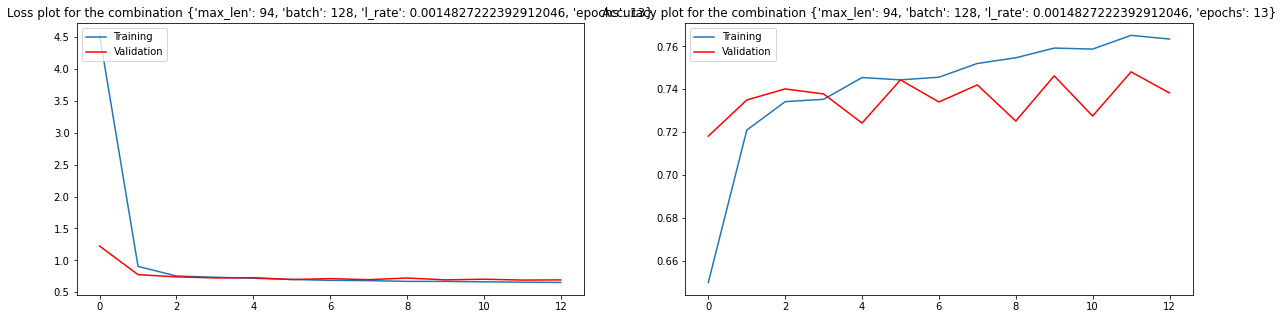

100%|██████████| 10/10 [02:28<00:00, 14.82s/it, best loss: -0.75]
{'batch_size': 1, 'epochs': 11, 'learning_rate': 0.0019321962879111313, 'max_length': 27}


In [29]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_lstm_em(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_lstm_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_lstm_em)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

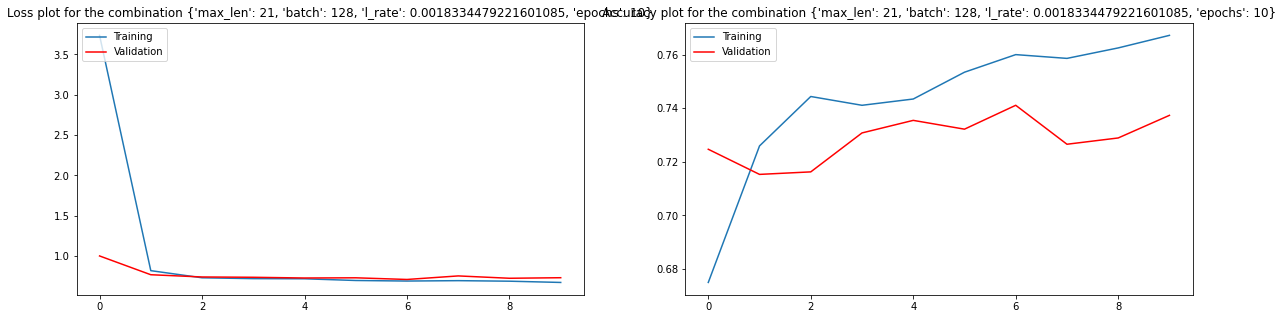

 10%|█         | 1/10 [00:07<01:05,  7.30s/it, best loss: -0.74]

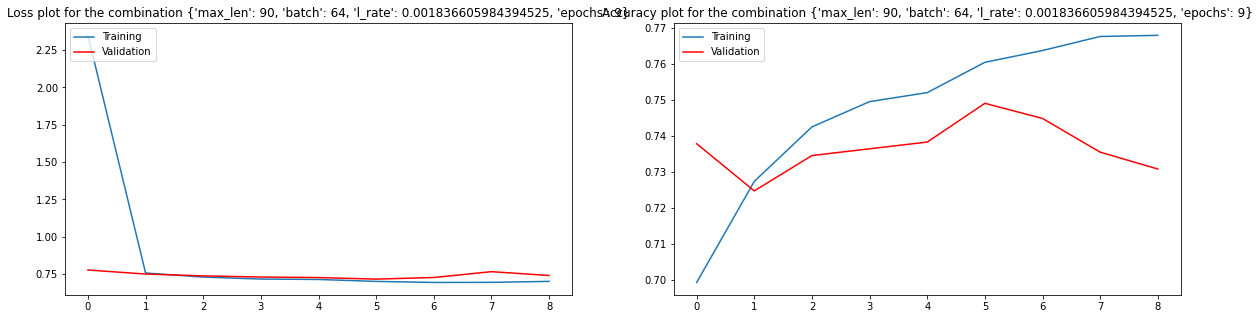

 20%|██        | 2/10 [00:24<01:22, 10.33s/it, best loss: -0.74]

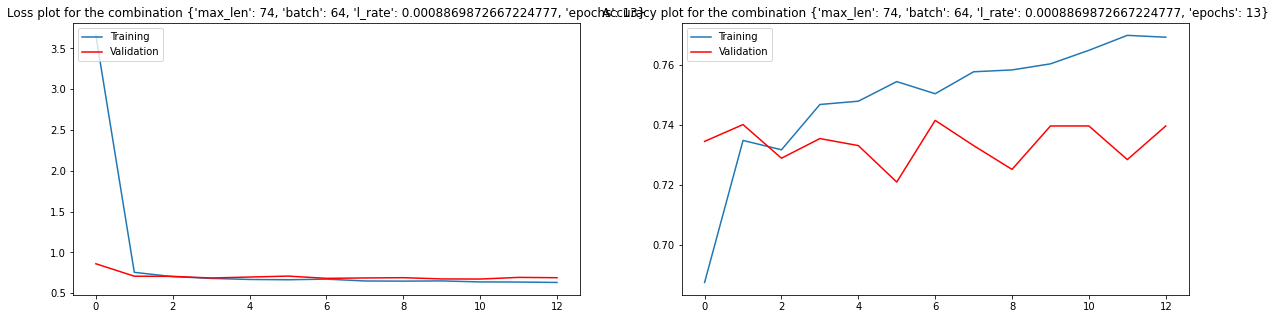

 30%|███       | 3/10 [00:46<01:35, 13.63s/it, best loss: -0.74]

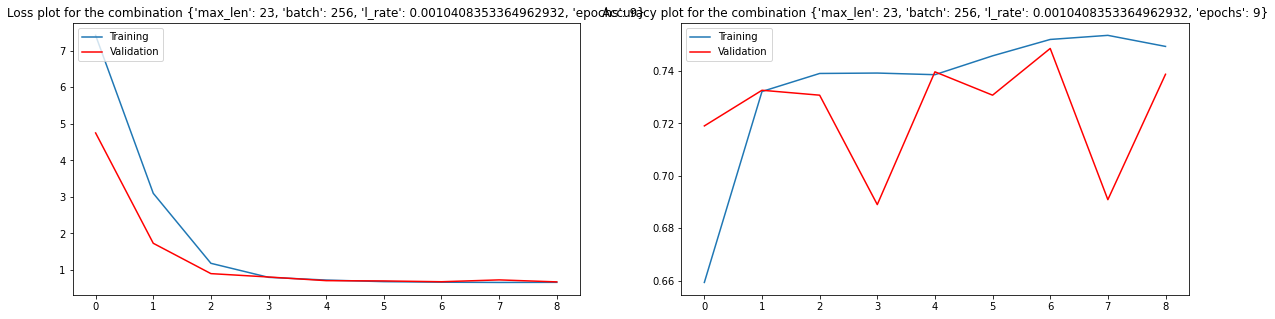

 40%|████      | 4/10 [00:51<01:07, 11.28s/it, best loss: -0.74]

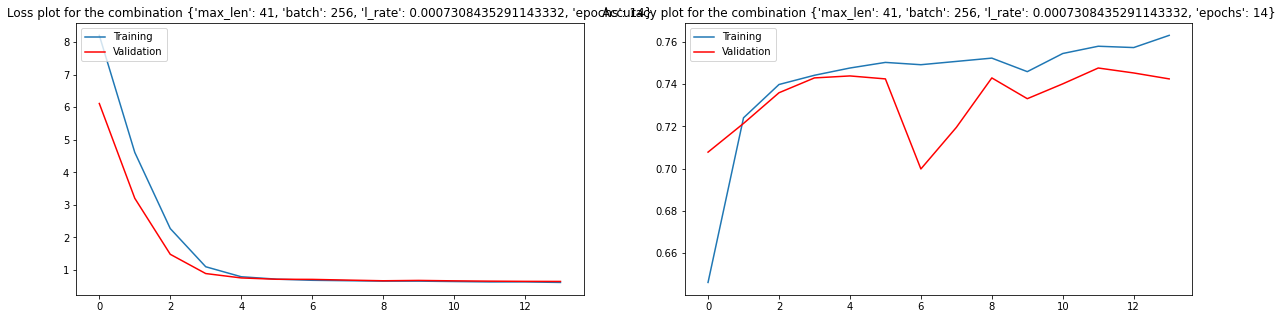

 50%|█████     | 5/10 [01:01<00:54, 10.94s/it, best loss: -0.74]

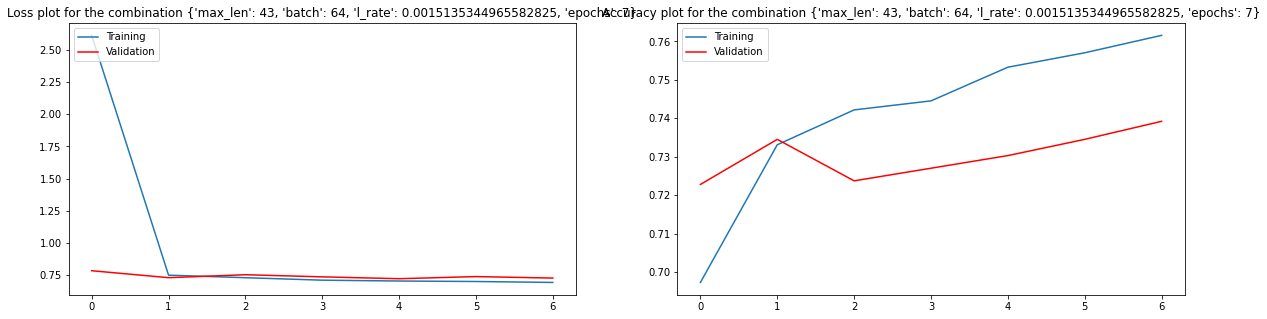

 60%|██████    | 6/10 [01:11<00:42, 10.51s/it, best loss: -0.74]

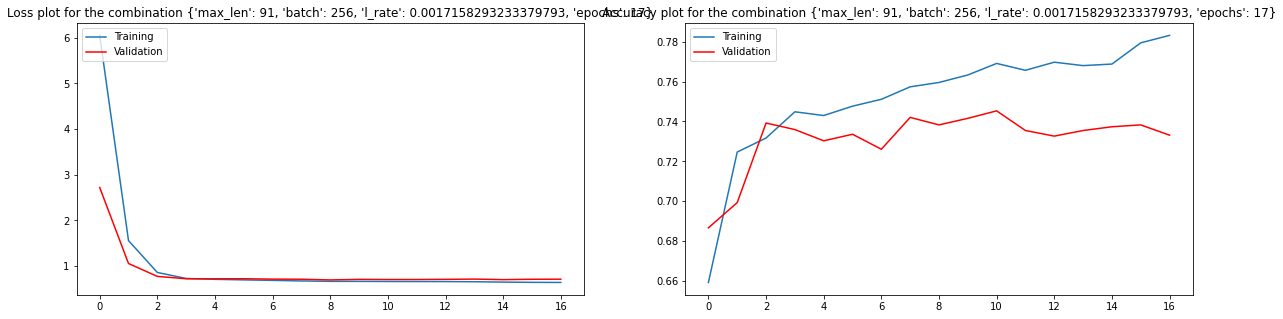

 70%|███████   | 7/10 [01:30<00:39, 13.21s/it, best loss: -0.74]

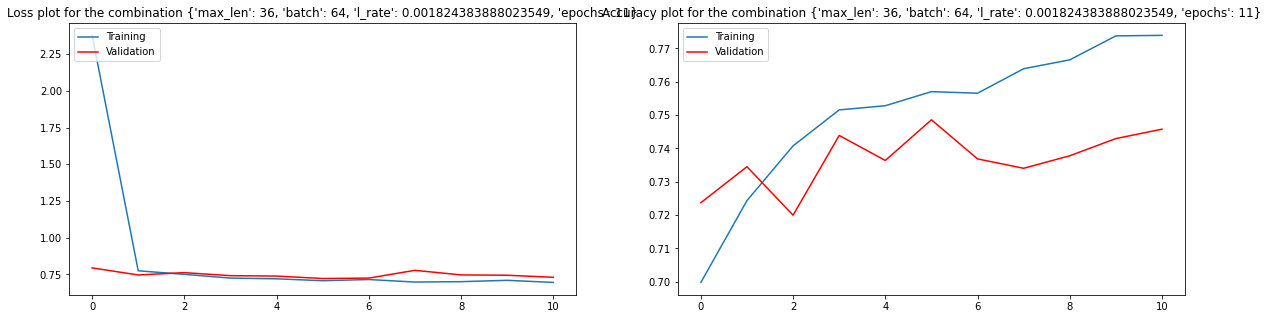

 80%|████████  | 8/10 [01:43<00:26, 13.09s/it, best loss: -0.75]

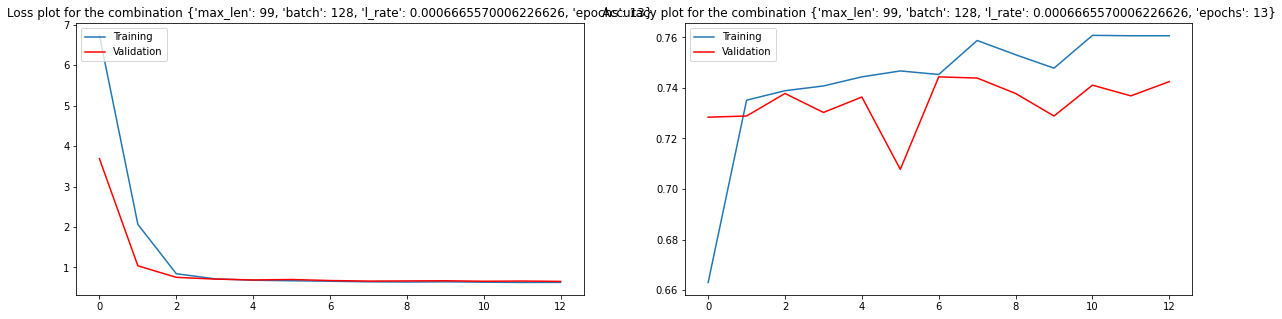

 90%|█████████ | 9/10 [02:03<00:15, 15.05s/it, best loss: -0.75]

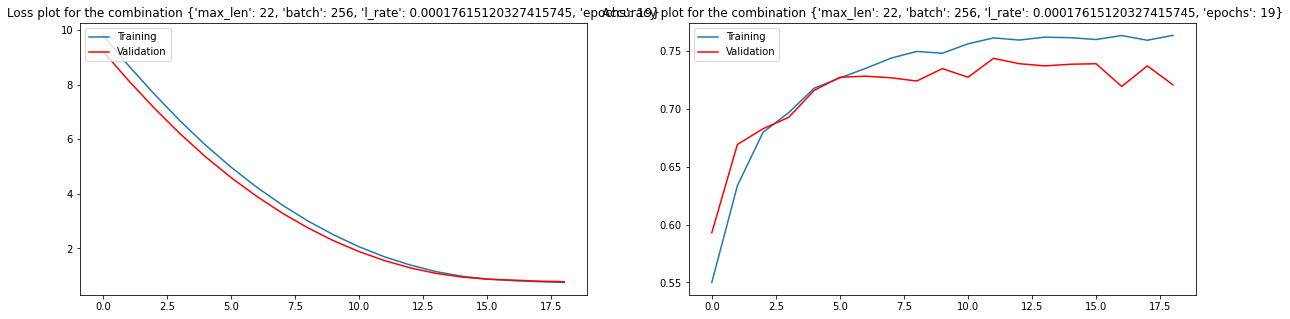

100%|██████████| 10/10 [02:12<00:00, 13.27s/it, best loss: -0.75]
{'batch_size': 0, 'epochs': 6, 'learning_rate': 0.001824383888023549, 'max_length': 32}


In [30]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_gru_em(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_gru_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_gru_em)

In [31]:
# training.to_csv('Training Data.csv')
# test.to_csv('Test Data.csv')

In [ ]:
# def generate_embedding_matrix(word_embeddings):
#     vocabulary_size = len(tokenizer.word_index)+1
#     embedding_matrix = np.zeros((vocabulary_size, 300))
#     for word, index in tokenizer.word_index.items():
#         embedding_vector = word_embeddings.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index] = embedding_vector
#     return embedding_matrix,vocabulary_size

In [ ]:
# input_len = 50
# tokenizer = Tokenizer(oov_token='<OOV>')
# tokenizer.fit_on_texts(training['Doc Text'])
# X_train_processed = tokenizer.texts_to_sequences(training['Doc Text'])
# X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=input_len,truncating='pre')
# embedding_matrix,vocabulary_size = generate_embedding_matrix(embeddings)
# tf.keras.backend.clear_session()
# model = Sequential()
# embedding_layer = Embedding(vocabulary_size, 300, weights=[embedding_matrix], input_length=input_len,trainable = False,mask_zero=True)
# model.add(embedding_layer)
# model.add(SimpleRNN(300,kernel_regularizer = tf.keras.regularizers.L1(0.01)))

# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# # adam_optimizer = optimizers.adam(learning_rate=learning_rate)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train_processed, training['Sentiment'], batch_size=128, epochs=30, verbose=1)

In [ ]:
def model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(SimpleRNN(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [ ]:
max_length = 40
epochs = 15
learning_rate = 0.001
batch_size = 64
encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model = model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.25)
accuracy = history.history['val_accuracy'][-1]

Epoch 1/15
126/126 [==============================] - 42s 335ms/step - loss: 5.1197 - accuracy: 0.6622 - val_loss: 2.0090 - val_accuracy: 0.6917
Epoch 2/15
126/126 [==============================] - 41s 324ms/step - loss: 1.2526 - accuracy: 0.7154 - val_loss: 0.8993 - val_accuracy: 0.7223
Epoch 3/15
126/126 [==============================] - 42s 337ms/step - loss: 0.8545 - accuracy: 0.7227 - val_loss: 0.8080 - val_accuracy: 0.7123
Epoch 4/15
126/126 [==============================] - 42s 333ms/step - loss: 0.7917 - accuracy: 0.7279 - val_loss: 0.7485 - val_accuracy: 0.7322
Epoch 5/15
126/126 [==============================] - 41s 324ms/step - loss: 0.7515 - accuracy: 0.7346 - val_loss: 0.7596 - val_accuracy: 0.7093
Epoch 6/15
126/126 [==============================] - 41s 323ms/step - loss: 0.7265 - accuracy: 0.7335 - val_loss: 0.7388 - val_accuracy: 0.7207
Epoch 7/15
126/126 [==============================] - 42s 333ms/step - loss: 0.7380 - accuracy: 0.7310 - val_loss: 0.7363 - val_ac

In [ ]:
def model_lstm_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(LSTM(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [ ]:
max_length = 40
epochs = 20
learning_rate = 0.001
batch_size = 128
encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model = model_lstm_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.25)
accuracy = history.history['val_accuracy'][-1]

Epoch 1/20
63/63 [==============================] - 74s 1s/step - loss: 9.0225 - accuracy: 0.6624 - val_loss: 1.3562 - val_accuracy: 0.7123
Epoch 2/20
63/63 [==============================] - 73s 1s/step - loss: 0.9291 - accuracy: 0.7110 - val_loss: 0.7748 - val_accuracy: 0.7314
Epoch 3/20
63/63 [==============================] - 76s 1s/step - loss: 0.7501 - accuracy: 0.7287 - val_loss: 0.7347 - val_accuracy: 0.7391
Epoch 4/20
63/63 [==============================] - 75s 1s/step - loss: 0.7241 - accuracy: 0.7325 - val_loss: 0.7345 - val_accuracy: 0.7207
Epoch 5/20
63/63 [==============================] - 74s 1s/step - loss: 0.7086 - accuracy: 0.7361 - val_loss: 0.7189 - val_accuracy: 0.7376
Epoch 6/20
63/63 [==============================] - 75s 1s/step - loss: 0.6910 - accuracy: 0.7414 - val_loss: 0.6886 - val_accuracy: 0.7406
Epoch 7/20
63/63 [==============================] - 75s 1s/step - loss: 0.6857 - accuracy: 0.7417 - val_loss: 0.6896 - val_accuracy: 0.7399
Epoch 8/20
63/63 [==

In [ ]:
def objective_func(args):
    max_length = args['max_length']
#     af_in_simpleRNN = args['af_in_simpleRNN']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
#     padd = args['padd']
#     trunc = args['trunc']
    epochs = args['epochs']
#     kernel_regularizer_coef = args['kernel_regularizer_coef']
#     activity_regularizer_coef = args['activity_regularizer_coef']
#     Dropout_rate = args['Dropout_rate']
    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)
    
    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()    
    
#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)), 
#          'af_in_simpleRNN': hp.choice('af_in_simpleRNN', ['tanh', 'sigmoid']), 
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
#          'padd': hp.choice('padd', ['pre', 'post']),
#          'trunc': hp.choice('trunc', ['pre', 'post']),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,1)
#          'Dropout_rate': hp.uniform('Dropout_rate', 0, 1),
#          'kernel_regularizer_coef': hp.uniform('kernel_regularizer_coef', 0, 10),
#          'activity_regularizer_coef': hp.uniform('activity_regularizer_coef', 0, 10)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn_bd = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn_bd)

  0%|          | 0/10 [20:12<?, ?trial/s, best loss=?]


KeyboardInterrupt: 